In [1]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_excel('data.xlsx')

In [5]:
df.head()

,DATE,data
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [9]:
df.set_index('DATE', inplace=True)

In [10]:
df.head()

,data
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [12]:
df.columns = ['Sales']

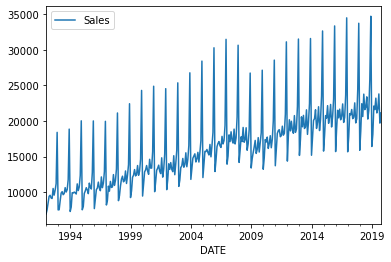

In [13]:
df.plot()

In [14]:
test_size = 18
test_ind = len(df)-test_size

In [15]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12

In [23]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [25]:
X, y = generator[0]

In [26]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [27]:
y

array([[0.02047633]])

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [29]:
n_features = 1

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape= (length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [31]:
validation_generator  = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=1)

In [32]:
model.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 9s 30ms/step - loss: 0.0251 - val_loss: 0.0051
Epoch 2/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0167 - val_loss: 0.0037
Epoch 3/20
304/304 [==============================] - 7s 23ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 4/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0054 - val_loss: 0.0046


In [33]:
losses = pd.DataFrame(model.history.history)

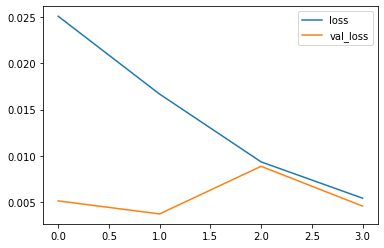

In [34]:
losses.plot()

In [37]:
test_pred = []

first_eval_batch  = scaled_train[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)


In [39]:
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_pred.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [40]:
true_preditions = scaler.inverse_transform(test_pred)

D:\Anaconda3\envs\DeepLearning TF modulekeras\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


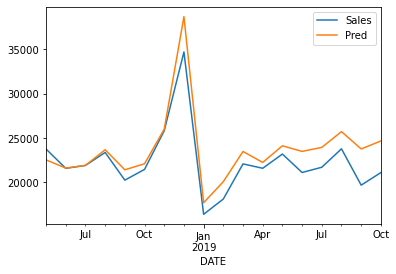

In [41]:
test['Pred'] = true_preditions
test.plot()

In [42]:
full_scaler = MinMaxScaler() 

In [43]:
scaled_full_data = full_scaler.fit_transform(df)
length=12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [44]:

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape= (length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
model.fit_generator(generator, epochs=8)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0256
Epoch 2/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0183
Epoch 3/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0089
Epoch 4/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0056
Epoch 5/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0027
Epoch 6/8
322/322 [==============================] - 7s 22ms/step - loss: 0.0016
Epoch 7/8
322/322 [=======

In [45]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

In [47]:
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [48]:
forecast = scaler.inverse_transform(forecast)

In [49]:
forecast

array([[26294.6042099 ],
       [35826.20935535],
       [17450.26366472],
       [18959.41146755],
       [22316.29837894],
       [21926.37774897],
       [23403.09934092],
       [21568.98840189],
       [22131.89369774],
       [24030.82258177],
       [20513.00063109],
       [21855.28831768]])

In [52]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [53]:
forecast_ind = pd.date_range(start='2019-11-01', periods=periods, freq='MS')

In [54]:
forecast_ind

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [55]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_ind, columns=['Forecast'])

In [56]:
forecast_df

,Forecast
2019-11-01,26294.604210
2019-12-01,35826.209355
2020-01-01,17450.263665
2020-02-01,18959.411468
2020-03-01,22316.298379
2020-04-01,21926.377749
2020-05-01,23403.099341
2020-06-01,21568.988402
2020-07-01,22131.893698
2020-08-01,24030.822582


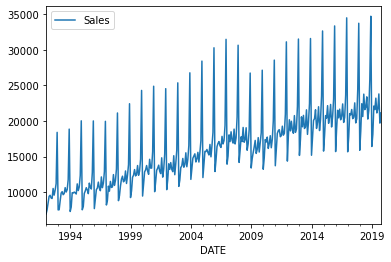

In [57]:
df.plot()

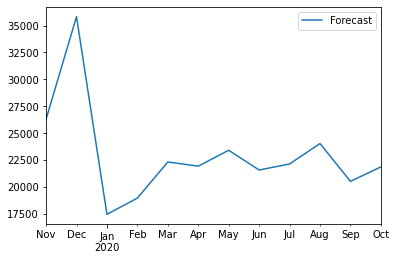

In [58]:
forecast_df.plot()

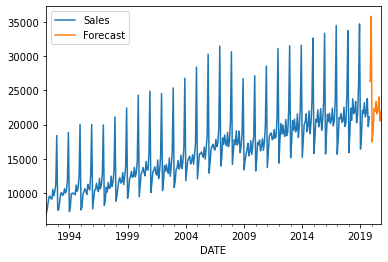

In [59]:
ax = df.plot()

forecast_df.plot(ax=ax)